In [13]:
from fastbook import *
from fastai.vision.widgets import *

In [14]:
key = os.environ.get('AZURE_SEARCH_KEY', '092ccf676dcc48ceab05a9e499b3c8fb')

In [15]:
search_images_bing

<function fastbook.search_images_bing(key, term, min_sz=128)>

In [16]:
results = search_images_bing(key, 'pancake')
ims = results.attrgot('content_url')
len(ims)

150

In [17]:
ims = ['https://preppykitchen.com/wp-content/uploads/2019/08/Pancakes-recipe-1200.jpg']

In [18]:
dest = 'images/pancake.jpg'
download_url(ims[0], dest)

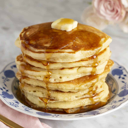

In [19]:
im = Image.open(dest)
im.to_thumb(128, 128)

In [20]:
food_types = 'pancake', 'waffle'
path = Path('food')

In [59]:
if not path.exists():
    path.mkdir()
    for o in food_types:
        dest = (path/o)
        dest.mkdir(exist_ok = True)
        results = search_images_bing(key, f'{o}food')
        download_images(dest, urls = results.attrgot('content_url'))

In [60]:
fns = get_image_files(path)
fns

(#274) [Path('food/pancake/00000038.jpg'),Path('food/pancake/00000010.jpg'),Path('food/pancake/00000004.jpg'),Path('food/pancake/00000005.jpg'),Path('food/pancake/00000011.jpg'),Path('food/pancake/00000007.jpg'),Path('food/pancake/00000013.jpg'),Path('food/pancake/00000044.gif'),Path('food/pancake/00000012.JPG'),Path('food/pancake/00000006.jpg')...]

In [61]:
failed = verify_images(fns)
failed

(#0) []

In [62]:
failed.map(Path.unlink);

In [63]:
foods = DataBlock(
    blocks = (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    splitter = RandomSplitter(valid_pct=0.2, seed = 42),
    get_y = parent_label,
    item_tfms = Resize(128))

In [64]:
dls = foods.dataloaders(path)

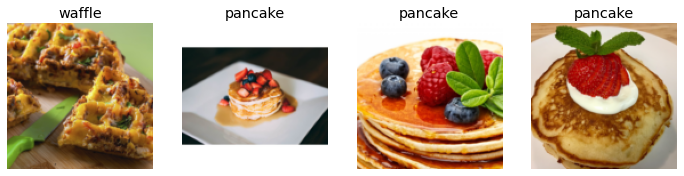

In [65]:
dls.valid.show_batch(max_n=4, nrows = 1)

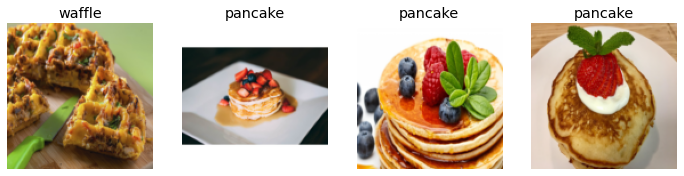

In [66]:
foods = foods.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = foods.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows = 1)

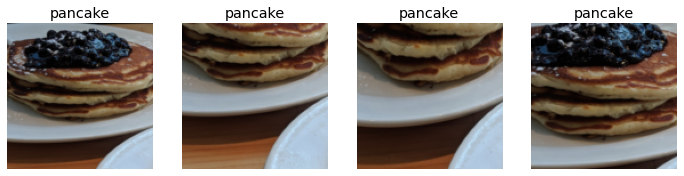

In [67]:
foods = foods.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = foods.dataloaders(path)
dls.train.show_batch(max_n = 4, nrows = 1, unique = True)

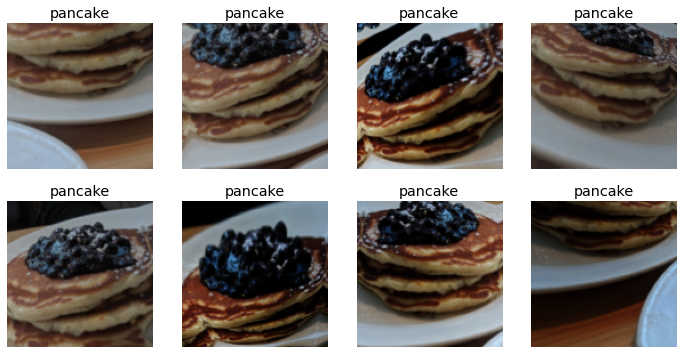

In [68]:
foods = foods.new(item_tfms=Resize(128), batch_tfms = aug_transforms(mult = 2))
dls = foods.dataloaders(path)
dls.train.show_batch(max_n = 8, nrows = 2, unique = True)

In [69]:
foods = foods.new(
    item_tfms=RandomResizedCrop(224, min_scale = 0.5),
    batch_tfms=aug_transforms())
dls = foods.dataloaders(path)

In [72]:
learn = cnn_learner(dls, resnet18, metrics = error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.131882,1.426395,0.370370,00:33


/Users/siddharthsah/opt/anaconda3/lib/python3.8/site-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


epoch,train_loss,valid_loss,error_rate,time
0,0.829720,0.504602,0.240741,00:44
1,0.696832,0.405393,0.185185,00:43
2,0.604893,0.407192,0.203704,00:43
3,0.564727,0.412303,0.203704,00:44


/Users/siddharthsah/opt/anaconda3/lib/python3.8/site-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/Users/siddharthsah/opt/anaconda3/lib/python3.8/site-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/Users/siddharthsah/opt/anaconda3/lib/python3.8/site-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/Users/siddharthsah/opt/anaconda3/lib/python3.8/site-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


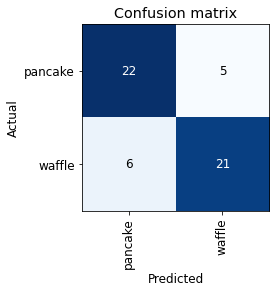

In [74]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

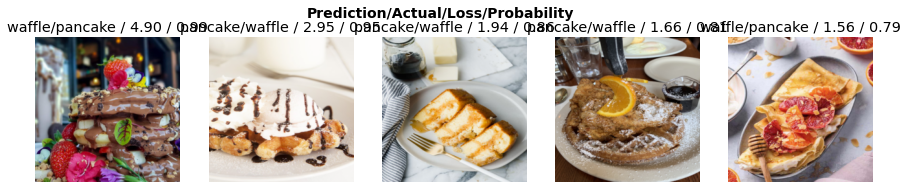

In [75]:
interp.plot_top_losses(5, nrows = 1)

In [76]:
cleaner = ImageClassifierCleaner(learn)
cleaner

/Users/siddharthsah/opt/anaconda3/lib/python3.8/site-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [57]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()

In [58]:
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [77]:
learn.export()

In [78]:
path = Path()
path.ls(file_exts = '.pkl')

(#1) [Path('export.pkl')]

In [79]:
learn_inf = load_learner(path/'export.pkl')

In [80]:
learn_inf.predict('images/pancake.jpg')

('pancake', tensor(0), tensor([0.9821, 0.0179]))

In [81]:
learn_inf.dls.vocab

(#2) ['pancake','waffle']

In [82]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [83]:
img = PILImage.create(btn_upload.data[-1])

In [85]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl : display(img.to_thumb(128,128))
out_pl

Output()

In [86]:
pred, pred_idx, probs = learn_inf.predict(img)

In [89]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: pancake; Probability: 0.9821')

In [90]:
btn_run = widgets.Button(description = 'Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [91]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [92]:
btn_upload = widgets.FileUpload()

In [93]:
VBox([widgets.Label('Select your bear!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

In [94]:
!pip install voila
!jupyter serverextension enable voila —sys-prefix

     |████████████████████████████████| 6.9 MB 6.0 MB/s eta 0:00:01
     |████████████████████████████████| 65 kB 6.6 MB/s eta 0:00:01
     |████████████████████████████████| 208 kB 7.7 MB/s eta 0:00:01
     |████████████████████████████████| 552 kB 6.6 MB/s eta 0:00:01
  Attempting uninstall: nbconvert
    Found existing installation: nbconvert 5.6.1
    Uninstalling nbconvert-5.6.1:
      Successfully uninstalled nbconvert-5.6.1
ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

spyder 4.1.5 requires pyqt5<5.13; python_version >= "3", which is not installed.
spyder 4.1.5 requires pyqtwebengine<5.13; python_version >= "3", which is not installed.
nbdev 1.0.18 requires nbconvert<6, but you'll have nbconvert 6.0.7 which is incompatible.
Enabling: 